# Predictive maintenance with classification models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from timeit import default_timer as timer   # for measuring computation time
from pympler import asizeof                 # for measuring ML object size

# import self defined functions
from add_remaining_useful_life import add_remaining_useful_life
from evaluate import evaluate
from determine_rul import determine_rul

In [2]:
dir_path = './input/'
train_file = 'PM_train.txt'
train_location = dir_path + train_file
test_file = 'PM_test.txt'
test_location = dir_path + test_file
truth_file = 'PM_truth.txt'
truth_location = dir_path + truth_file

index_names = ['id', 'cycle']
setting_names = ['setting1', 'setting2', 'setting3']
sensor_names = ['s{}'.format(i+1) for i in range(0, 21)]
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv(train_location, sep='\s+', header=None, names=col_names)    # s+ -> regex for spaces/tabs as spaces
test = pd.read_csv(test_location, sep='\s+', header=None, names=col_names)
y_truth = pd.read_csv(truth_location, sep='\s+', header=None, names=['RUL'])

print(train.shape)

(20631, 26)


In [3]:
# Computation of RUL
train = add_remaining_useful_life(train)
test = add_remaining_useful_life(test)
train[index_names+['RUL']].head()

,id,cycle,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [4]:
# adjust RUL value by truth values
for i in range(len(test)):
    currentID = test['id'][i]
    current_truth_value = y_truth['RUL'][currentID - 1]
    test['RUL'][i] = test['RUL'][i] + current_truth_value


In [5]:
# add TTL (time to failure) variable
period = 30

train['label_bc'] = train['RUL'].apply(lambda y: 1 if y <= period else 0)
test['label_bc'] = test['RUL'].apply(lambda y: 1 if y <= period else 0) 
train.tail()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label_bc
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4,1
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3,1
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2,1
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1,1
20630,100,200,-0.0032,-0.0005,100.0,518.67,643.85,1600.38,1432.14,14.62,...,8137.33,8.5036,0.03,396,2388,100.0,38.37,23.0522,0,1


In [6]:
# define test and training features
drop_sensors = 's1 s5 s6 s10 s16 s18 s19'.split(' ')
drop_labels = index_names+setting_names+drop_sensors
remaining_sensors = 's2 s3 s4 s7 s8 s9 s11 s12 s13 s14 s15 s17 s20 s21'.split(' ')

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('label_bc')
X_test = test.drop(drop_labels, axis=1)
y_test = X_test.pop('label_bc')

X_train.drop('RUL', axis=1, inplace=True)
X_test.drop('RUL', axis=1, inplace=True)

id_test = np.reshape(np.array(test['id']),((X_test.shape[0],1)))
id_train = np.reshape(np.array(train['id']),((X_train.shape[0],1)))

The other method to predict the RUL is using classification models. In order to effectively use a classification method a proper feature has to be added. 
In this dataset, we classify if certain sensor values lead to a failure of a system. A failure is marked as 1, whereas a proper operation has 0 as its value. 
We also define a TTF (time to failure) time and a 'period' variable which defines the number of cycles left until RUL. 

## Random Forest as classification model

In [8]:
rf_clas = RandomForestClassifier(n_estimators=500, random_state=42, max_depth=15)

# fit model
rf_clas.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [9]:
# predictions
predictions = rf_clas.predict(X_test)
errors = abs(predictions - y_test)

# Print out the mean absolute error
print('Mean Absolute Error:', round(np.mean(errors), 2))    # cannot compare regression/classification errors 

Mean Absolute Error: 0.01


In [10]:
print('Accuracy of model on test data: ',accuracy_score(np.array(y_test), predictions))
print('Confusion Matrix: \n',confusion_matrix(np.array(y_test), predictions))

Accuracy of model on test data:  0.9868662186927306
Confusion Matrix: 
 [[12719    45]
 [  127   205]]


## KNN Model

In [24]:
# find best number of neighbours
accuracy_n = np.zeros(50)
for n in range(1, accuracy_n.shape[0]):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    accuracy_n[n] = knn.score(X_test, y_test)

KeyboardInterrupt: 

0.9834300549786195


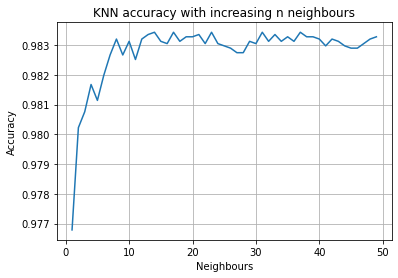

In [12]:
# plot accuracy depending on #neighbours
N = np.arange(0, accuracy_n.shape[0])
plt.plot(N[1:50], accuracy_n[1:50])
plt.xlabel('Neighbours')
plt.ylabel('Accuracy')
plt.title('KNN accuracy with increasing n neighbours')
print(accuracy_n.max())
plt.grid(True)

An ideal number of neighbours would be 23. With further increase of the number of neighbors the accuracy cannot be drastically improved. Thus, n = 23 is chosen for the KNN model design. 

In [13]:
#KNN model with N = 23
knn = KNeighborsClassifier(n_neighbors = 23)
start_knn = timer()
knn.fit(X_train, y_train)
end_knn = timer()
time_knn = end_knn - start_knn
print('time for training of knn Model: ' + str(round(time_knn,2))+ ' s')
knn_size = asizeof.asizeof(knn)/1e6
print('Memory allocation of knn objekt: ' + str(round(knn_size,2))+ ' MB')

time for training of knn Model: 0.04 s
Memory allocation of knn objekt: 2.4 MB


In [14]:
Y_pred_KNN = knn.predict(X_test)
confusion_matrix_KNN = confusion_matrix(y_test, Y_pred_KNN)
accuracy_KNN = knn.score(X_test, y_test)
print('Confusion Matrix: \n',confusion_matrix_KNN)
print('accuracy:', accuracy_KNN)

Confusion Matrix: 
 [[12709    55]
 [  162   170]]
accuracy: 0.9834300549786195


### Calculation of RUL for KNN model

In [23]:
rul_list_knn = determine_rul(Y_pred_KNN, y_test, id_test, period)
print((rul_knn))

[ 0. 30. 30. ... 14. 13.  0.]


In [20]:
# evaluate RSME
rsme_knn = evaluate(y_truth, rul_knn, label='knn')

ValueError: Found input variables with inconsistent numbers of samples: [100, 13096]

## Support vector machine (SVM) model

In [7]:
# find the best factor "C"
accuracy_C = np.zeros(50)
for i in range (1, accuracy_C.shape[0]):
    logreg = LogisticRegression(C=i).fit(X_train, y_train) # C: Unregelmädigkeitsfaktor
    accuracy_C [i] = logreg.score(X_test, y_test)

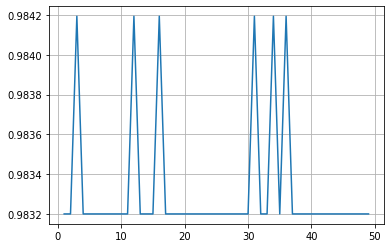

In [8]:
# plot C
C = np.arange(0, accuracy_C.shape[0])
plt.plot(C[1:50], accuracy_C[1:50])
plt.grid(True)

In [9]:
# for C = 8:
start_SVM = timer()
logreg = LogisticRegression(C=8).fit(X_train, y_train)
end_SVM = timer()
time_SVM = end_SVM - start_SVM
print('time for training of SVM Model: ' + str(round(time_SVM,2))+ ' s')
SVM_size = asizeof.asizeof(logreg)
print('Memory allocation of SMV objekt: ' + str(round(SVM_size,2))+ ' MB')

time for training of SVM Model: 0.12 s
Memory allocation of SMV objekt: 2440 MB


In [10]:
Y_pred_SVM = logreg.predict(X_test)
confusion_matrix_SVM = confusion_matrix(y_test, Y_pred_SVM)
accuracy_SVM = logreg.score(X_test, y_test)
print('Confusion Matrix: \n',confusion_matrix_SVM)
print('accuracy:', accuracy_SVM)

Confusion Matrix: 
 [[12706    58]
 [  162   170]]
accuracy: 0.9832009773976786


In [16]:
rul_list_svm = determine_rul(Y_pred_SVM, y_test, X_test, test, period)

100
[30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 20.0, 30.0, 30.0, 30.0, 25.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 7.0, 30.0, 30.0, 21.0, 7.0, 18.0, 30.0, 30.0, 30.0, 20.0, 30.0, 27.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 22.0, 30.0, 30.0, 29.0, 28.0, 30.0, 30.0, 20.0, 30.0, 30.0, 30.0, 30.0, 27.0, 30.0, 30.0, 29.0, 30.0, 16.0, 30.0, 14.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 10.0, 30.0, 30.0, 30.0, 30.0, 9.0, 24.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 25.0, 24.0, 24.0, 24.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 0.0]


In [17]:
# evaluate using Regression evaluation
evaluate(y_truth, rul_list_svm, label='svn')

svn set RMSE:61.41791269654155, R2:-1.184391919343534


61.41791269654155

# Determining RUL 
The predictions result only in an array, which classifies if a certain set of sensor values qualifies as part of the class or not. 

In [13]:
# plot prediction to get a better idea
prediction_data = test['id cycle'.split(' ')]
prediction_data['label_bc'] = predictions
# prediction_data['failure'] = 
# print(prediction_data['id'].max())
# print(len(prediction_data))
prediction_data['failure'] = np.zeros(len(prediction_data))

# print(prediction_data['id'][0])
# print(prediction_data['cycle'][13000])
# print(y_test['RUL'][currentID])
# print(prediction_data['failure'][13000])

# for i in range(0, 12999):
#     currentID = prediction_data['id'][i] - 1
#     if prediction_data['cycle'][i] == y_test['RUL'][currentID]:
#         prediction_data['failure'][i] = 1

print(type(prediction_data))
plt.plot(predictions[4500:4600])
# plt.plot(predictions)
# prediction_data.head()
y_test.head()
print(len(prediction_data))
# prediction_data['id'][400]
prediction_data.head()

NameError: name 'predictions' is not defined